In [13]:
import os
import json
import random
import warnings
import numpy as np
from tqdm import tqdm
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import torch
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from resnet_wider import resnet50x1, resnet50x2, resnet50x4

In [14]:
train_path_to_imagenet = "/hdd2/datasets/imagenet/train"
val_path_to_imagenet = "/hdd2/datasets/imagenet/val/"
parameter_path = "resnet50-1x.pth"
num_of_sampled_classes = 100
tree_structure = "mintree"
per_class = 50

### Load tree structure and label info

In [15]:
T = nx.Graph()

with open('./imagenet_' + tree_structure + '.txt', 'r') as f:
    for line in f.readlines():
        nodes = line.split()
        for node in nodes:
            if node not in T:
                T.add_node(node)
        T.add_edge(*nodes)
        
leaves = [x for x in T.nodes() if T.degree(x) == 1]
full_labels_loc = np.array(leaves)
length = dict(nx.all_pairs_shortest_path_length(T))

In [16]:
f = open('./dir_label_name.json')
map_collection = json.load(f)
f.close()

In [17]:
# map_collection

### Compute squared distance matrix

In [18]:
np.random.seed(123)
sampled_classes = np.random.choice(len(full_labels_loc), num_of_sampled_classes, replace=False)
sampled_classes = np.sort(sampled_classes)  
sampled_classes

array([  5,   7,  41,  43,  50,  85, 114, 131, 134, 138, 145, 147, 156,
       161, 167, 171, 172, 182, 184, 195, 196, 203, 209, 221, 229, 266,
       274, 299, 310, 317, 318, 320, 327, 328, 336, 338, 345, 346, 352,
       353, 372, 378, 387, 392, 417, 426, 437, 447, 461, 479, 536, 542,
       548, 558, 566, 585, 590, 594, 597, 607, 613, 632, 633, 640, 642,
       648, 656, 691, 693, 702, 713, 722, 736, 743, 761, 771, 784, 786,
       803, 805, 808, 814, 822, 830, 874, 877, 882, 896, 901, 917, 924,
       932, 934, 938, 965, 971, 983, 985, 986, 994])

In [19]:
"""
squared_distance_matrix = np.zeros((len(sampled_classes), len(full_labels_loc)))

for i, sample_class in enumerate(sampled_classes):
    for j, each_class_loc in enumerate(full_labels_loc):
        sample_class_loc = map_collection[str(sample_class)][0]
        distance = length[sample_class_loc][each_class_loc]
        squared_distance_matrix[i][j] = distance ** 2
"""

'\nsquared_distance_matrix = np.zeros((len(sampled_classes), len(full_labels_loc)))\n\nfor i, sample_class in enumerate(sampled_classes):\n    for j, each_class_loc in enumerate(full_labels_loc):\n        sample_class_loc = map_collection[str(sample_class)][0]\n        distance = length[sample_class_loc][each_class_loc]\n        squared_distance_matrix[i][j] = distance ** 2\n'

In [20]:
squared_distance_matrix = np.zeros((len(full_labels_loc), len(full_labels_loc)))

for i, each_class_loc_i in enumerate(full_labels_loc):
    for j, each_class_loc_j in enumerate(full_labels_loc):
        distance = length[each_class_loc_i][each_class_loc_j]
        squared_distance_matrix[i][j] = distance ** 2

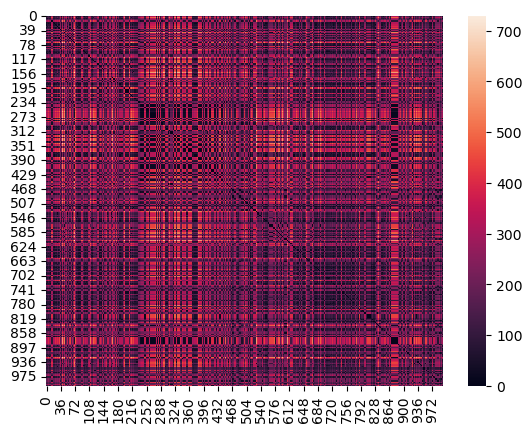

In [21]:
sns.heatmap(squared_distance_matrix)
plt.show()

### Load parameters from pretrained SimCLR 

In [22]:
model = resnet50x1()
sd = torch.load(parameter_path, map_location='cpu')
model.load_state_dict(sd["state_dict"])
model = model.to('cuda:0')

### Extract image embeddings from SimCLR

In [23]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [24]:
torch.manual_seed(123)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_path_to_imagenet, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])),
    batch_size=256, shuffle=True,
    num_workers=10, pin_memory=False)

training_embedding_collection = []
training_ground_truth_collection = []
for i, (images, target) in tqdm(enumerate(train_loader), total=300):
    if i > 299: break
    images_cuda = images.to("cuda:0")
    activation = {}
    model.eval()
    with torch.no_grad():
        ## get embeddings from encoder, right before linear projection ##
        model.avgpool.register_forward_hook(get_activation('avgpool'))
        output = model(images_cuda)
        embeddings = torch.squeeze(activation['avgpool']).cpu().detach().numpy()
        training_embedding_collection.extend(embeddings)
    training_ground_truth_collection.extend(target.detach().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.91it/s]


In [25]:
training_embedding_collection = np.array(training_embedding_collection)
training_ground_truth_collection = np.array(training_ground_truth_collection)
print(training_embedding_collection.shape, training_ground_truth_collection.shape)

(76800, 2048) (76800,)


In [26]:
torch.manual_seed(123)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_path_to_imagenet, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])),
    batch_size=256, shuffle=True,
    num_workers=10, pin_memory=False)

validation_embedding_collection = []
validation_ground_truth_collection = []
for i, (images, target) in tqdm(enumerate(val_loader), total=196):
    images_cuda = images.to("cuda:0")
    activation = {}
    model.eval()
    with torch.no_grad():
        ## get embeddings from encoder, right before linear projection ##
        model.avgpool.register_forward_hook(get_activation('avgpool'))
        output = model(images_cuda)
        embeddings = torch.squeeze(activation['avgpool']).cpu().detach().numpy()
        validation_embedding_collection.extend(embeddings)
    validation_ground_truth_collection.extend(target.detach().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:04<00:00,  3.02it/s]


In [27]:
validation_embedding_collection = np.array(validation_embedding_collection)
validation_ground_truth_collection = np.array(validation_ground_truth_collection)
print(validation_embedding_collection.shape, validation_ground_truth_collection.shape)

(50000, 2048) (50000,)


In [28]:
train_X = training_embedding_collection
train_y = training_ground_truth_collection
test_X = validation_embedding_collection
test_y = validation_ground_truth_collection

### Remove data outside sampled classes

In [29]:
sampled_index = []
for sample_class in sampled_classes:
    sampled_index.extend(np.where(train_y == sample_class)[0][:per_class])
sampled_index = np.array(sampled_index)

In [30]:
sampled_train_X = train_X[sampled_index]
sampled_train_y = train_y[sampled_index]

In [31]:
sampled_train_X.shape, sampled_train_y.shape, test_X.shape, test_y.shape

((4995, 2048), (4995,), (50000, 2048), (50000,))

In [32]:
unique_elements, counts_elements = np.unique(sampled_train_y, return_counts=True)
print(unique_elements, counts_elements)

[  5   7  41  43  50  85 114 131 134 138 145 147 156 161 167 171 172 182
 184 195 196 203 209 221 229 266 274 299 310 317 318 320 327 328 336 338
 345 346 352 353 372 378 387 392 417 426 437 447 461 479 536 542 548 558
 566 585 590 594 597 607 613 632 633 640 642 648 656 691 693 702 713 722
 736 743 761 771 784 786 803 805 808 814 822 830 874 877 882 896 901 917
 924 932 934 938 965 971 983 985 986 994] [50 50 50 50 50 50 50 50 50 50 50 50 50 50 45 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50]


### Train logistic regression with one-vs-rest Method

In [33]:
clf = OneVsRestClassifier(LogisticRegression(random_state=0, max_iter=500), n_jobs=-1).fit(sampled_train_X, sampled_train_y)
pred_prob = clf.predict_proba(test_X)

In [34]:
pred_prob.shape

(50000, 100)

### Argmax pred_prob to generate prediction

In [35]:
prediction = sampled_classes[np.argmax(pred_prob, axis=1)]

### Compute average squared distance over all the testing data

In [36]:
avg_squared_distance = 0
for pred, gt in zip(prediction, test_y):
    avg_squared_distance += squared_distance_matrix[pred][gt]
avg_squared_distance = avg_squared_distance / len(test_y)
print("SimCLR + LG, AVG Squared Distance: ", avg_squared_distance)

SimCLR + LG, AVG Squared Distance:  184.30278


---------------------

### With proposed label model

In [37]:
prediction_w_label_model = np.argmin(np.dot(pred_prob, squared_distance_matrix[sampled_classes]), axis=1)

In [38]:
"""
def fréchet_variance(y, L, w, d):
    v = 0
    for i, sample_class in enumerate(L):
        v += w[i] * (d[i][y])
    return v

def fréchet_mean(L, w, d):
    Y = np.arange(len(full_labels_loc))
    return np.argmin([fréchet_variance(y, L, w, d) for y in Y])
    
prediction_w_label_model = []
for p_num, (prob, gt) in tqdm(enumerate(zip(pred_prob, test_y)), total=len(test_y)):
    argmin_y = fréchet_mean(sampled_classes, prob, squared_distance_matrix)
    prediction_w_label_model.append(argmin_y)
"""

'\ndef fréchet_variance(y, L, w, d):\n    v = 0\n    for i, sample_class in enumerate(L):\n        v += w[i] * (d[i][y])\n    return v\n\ndef fréchet_mean(L, w, d):\n    Y = np.arange(len(full_labels_loc))\n    return np.argmin([fréchet_variance(y, L, w, d) for y in Y])\n    \nprediction_w_label_model = []\nfor p_num, (prob, gt) in tqdm(enumerate(zip(pred_prob, test_y)), total=len(test_y)):\n    argmin_y = fréchet_mean(sampled_classes, prob, squared_distance_matrix)\n    prediction_w_label_model.append(argmin_y)\n'

In [39]:
avg_squared_distance_w_label_model = 0
for pred, gt in zip(prediction_w_label_model, test_y):
    avg_squared_distance_w_label_model += squared_distance_matrix[pred][gt]
avg_squared_distance_w_label_model = avg_squared_distance_w_label_model / len(test_y)
print("SimCLR + LG + Label Model, AVG Squared Distance: ", avg_squared_distance_w_label_model)

SimCLR + LG + Label Model, AVG Squared Distance:  136.43372
